## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [2]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [13]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
PATIENCES = [1,3,5]
FACTORS = [0.1,0.5, 0.99]

In [17]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

In [15]:
results = {}
for i, pat in enumerate(PATIENCES):
    for j, fac in enumerate(FACTORS):
        keras.backend.clear_session()
        
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], 
                      optimizer=optimizer)
        
        reduce_lr = ReduceLROnPlateau(factor=fac, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=pat, 
                              verbose=1)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[reduce_lr]
                 )

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
        name_tag = f"model-patience:{str(pat)}_factors:{fac}"
        results[name_tag] = {'train-loss': train_loss,
                     'valid-loss': valid_loss,
                     'train-acc': train_acc,
                     'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Epoch 44/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.1305 - acc: 0.6146 - val_loss: 1.4472 - val_acc: 0.4864
Epoch 45/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.1319 - acc: 0.6136 - val_loss: 1.4472 - val_acc: 0.4864
Epoch 46/50
50000/50000 [==============================] - 9s 190us/step - loss: 1.1317 - acc: 0.6124 - val_loss: 1.4472 - val_acc: 0.4866
Epoch 47/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.1319 - acc: 0.6128 - val_loss: 1.4472 - val_acc: 0.4866
Epoch 48/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.1314 - acc: 0.6127 - val_loss: 1.4472 - val_acc: 0.4865
Epoch 49/50
50000/50000 [==============================] - 10s 190us/step - loss: 1.1317 - acc: 0.6139 - val_loss: 1.4472 - val_acc: 0.4864
Epoch 50/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.1314 - acc: 0.6133 - val_loss: 1.4471 - val_acc: 0.4866
________________________

50000/50000 [==============================] - 9s 187us/step - loss: 1.2006 - acc: 0.5862 - val_loss: 1.4709 - val_acc: 0.4859

Epoch 00033: ReduceLROnPlateau reducing learning rate to 7.629394893626795e-09.
Epoch 34/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.2017 - acc: 0.5854 - val_loss: 1.4709 - val_acc: 0.4861

Epoch 00034: ReduceLROnPlateau reducing learning rate to 3.814697446813398e-09.
Epoch 35/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.2010 - acc: 0.5863 - val_loss: 1.4709 - val_acc: 0.4861

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.907348723406699e-09.
Epoch 36/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.2011 - acc: 0.5853 - val_loss: 1.4709 - val_acc: 0.4863

Epoch 00036: ReduceLROnPlateau reducing learning rate to 9.536743617033494e-10.
Epoch 37/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.2011 - acc: 0.5862 - val_loss: 1.4709 - val_acc: 

50000/50000 [==============================] - 9s 173us/step - loss: 1.0067 - acc: 0.6589 - val_loss: 1.4518 - val_acc: 0.4967

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0009605961316265165.
Epoch 23/50
50000/50000 [==============================] - 9s 173us/step - loss: 0.9886 - acc: 0.6639 - val_loss: 1.4574 - val_acc: 0.4924

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0009509901772253215.
Epoch 24/50
50000/50000 [==============================] - 9s 174us/step - loss: 0.9643 - acc: 0.6746 - val_loss: 1.4633 - val_acc: 0.4904

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0009414802846731617.
Epoch 25/50
50000/50000 [==============================] - 9s 173us/step - loss: 0.9468 - acc: 0.6825 - val_loss: 1.4631 - val_acc: 0.4941

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0009320654743351042.
Epoch 26/50
50000/50000 [==============================] - 9s 173us/step - loss: 0.9250 - acc: 0.6900 - val_loss: 1.4644 - val_acc: 

Epoch 4/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.5432 - acc: 0.4606 - val_loss: 1.6301 - val_acc: 0.4321
Epoch 5/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.4872 - acc: 0.4797 - val_loss: 1.6153 - val_acc: 0.4338
Epoch 6/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.4427 - acc: 0.4965 - val_loss: 1.5707 - val_acc: 0.4496
Epoch 7/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.4043 - acc: 0.5103 - val_loss: 1.5531 - val_acc: 0.4573
Epoch 8/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.3694 - acc: 0.5232 - val_loss: 1.5332 - val_acc: 0.4571
Epoch 9/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.3359 - acc: 0.5349 - val_loss: 1.5218 - val_acc: 0.4664
Epoch 10/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.3065 - acc: 0.5438 - val_loss: 1.5074 - val_acc: 0.4787
Epoch 11/50
50000/50000 [========

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 188us/step - loss: 2.2300 - acc: 0.2737 - val_loss: 2.1167 - val_acc: 0.3037
Epoch 2/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.7506 - acc: 0.3901 - val_loss: 1.8434 - val_acc: 0.3766
Epoch 3/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.6238 - acc: 0.4313 - val_loss: 1.7091 - val_acc: 0.4044
Epoch 4/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.5501 - acc: 0.4573 - val_loss: 1.6441 - val_acc: 0.4326
Epoch 5/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.4946 - acc: 0.4754 - val_loss: 1.6042 - val_acc: 0.4367
Epoch 6/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.4504 - acc: 0.4923 - val_loss: 1.5668 - val_acc: 0.4506
Epoch 7/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.4106 - acc: 0.5065 - val_loss: 1.5533 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 193us/step - loss: 2.2288 - acc: 0.2683 - val_loss: 2.2125 - val_acc: 0.3094
Epoch 2/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.7433 - acc: 0.3954 - val_loss: 1.8115 - val_acc: 0.3836
Epoch 3/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.6199 - acc: 0.4338 - val_loss: 1.6931 - val_acc: 0.4053
Epoch 4/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.5507 - acc: 0.4580 - val_loss: 1.6293 - val_acc: 0.4278
Epoch 5/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.4974 - acc: 0.4765 - val_loss: 1.5962 - val_acc: 0.4334
Epoch 6/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.4534 - acc: 0.4929 - val_loss: 1.5561 - val_acc: 0.4508
Epoch 7/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.4142 - acc: 0.5062 - val_loss: 1.5495 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 189us/step - loss: 2.2278 - acc: 0.2668 - val_loss: 2.0995 - val_acc: 0.3079
Epoch 2/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.7470 - acc: 0.3926 - val_loss: 1.7853 - val_acc: 0.3804
Epoch 3/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.6217 - acc: 0.4318 - val_loss: 1.6839 - val_acc: 0.4149
Epoch 4/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.5490 - acc: 0.4579 - val_loss: 1.6229 - val_acc: 0.4295
Epoch 5/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.4954 - acc: 0.4780 - val_loss: 1.5822 - val_acc: 0.4447
Epoch 6/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.4478 - acc: 0.4961 - val_loss: 1.5694 - val_acc: 0.4528
Epoch 7/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.4101 - acc: 0.5091 - val_loss: 1.5444 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 194us/step - loss: 2.2067 - acc: 0.2712 - val_loss: 2.1091 - val_acc: 0.3156
Epoch 2/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.7418 - acc: 0.3909 - val_loss: 1.7971 - val_acc: 0.3821
Epoch 3/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.6167 - acc: 0.4316 - val_loss: 1.6801 - val_acc: 0.4153
Epoch 4/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.5455 - acc: 0.4576 - val_loss: 1.6175 - val_acc: 0.4332
Epoch 5/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.4908 - acc: 0.4774 - val_loss: 1.5976 - val_acc: 0.4404
Epoch 6/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.4466 - acc: 0.4952 - val_loss: 1.5592 - val_acc: 0.4493
Epoch 7/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.4061 - acc: 0.5101 - val_loss: 1.5511 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 227us/step - loss: 2.2123 - acc: 0.2702 - val_loss: 2.0437 - val_acc: 0.3286
Epoch 2/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.7431 - acc: 0.3954 - val_loss: 1.8123 - val_acc: 0.3747
Epoch 3/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.6186 - acc: 0.4339 - val_loss: 1.6987 - val_acc: 0.4022
Epoch 4/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.5451 - acc: 0.4597 - val_loss: 1.6498 - val_acc: 0.4195
Epoch 5/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.4874 - acc: 0.4795 - val_loss: 1.5929 - val_acc: 0.4381
Epoch 6/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.4428 - acc: 0.4962 - val_loss: 1.5800 - val_acc: 0.4416
Epoch 7/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.4019 - acc: 0.5089 - val_loss: 1.551

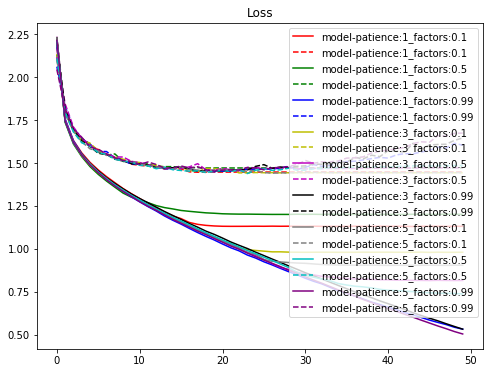

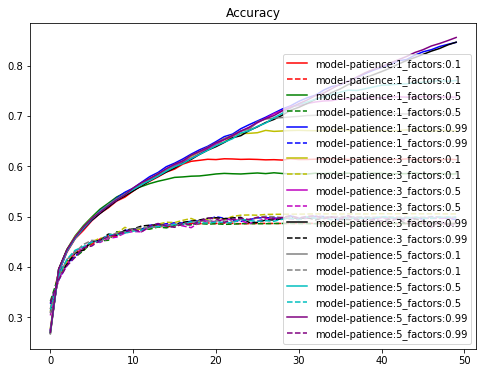

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k", "gray","c","purple"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [18]:
results = {}

keras.backend.clear_session()

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], 
              optimizer=optimizer)



model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[reduce_lr]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]
name_tag = f"model-patience:{str(pat)}_factors:{fac}"
results[name_tag] = {'train-loss': train_loss,
             'valid-loss': valid_loss,
             'train-acc': train_acc,
             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 9s 188us/step - loss: 0.3167 - acc: 0.9301 - val_loss: 1.6066 - val_acc: 0.5325
Epoch 46/50
50000/50000 [==============================] - 9s 188us/step - loss: 0.3158 - acc: 0.9290 - val_loss: 1.6106 - val_acc: 0.5326

Epoch 00046: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 47/50
50000/50000 [==============================] - 9s 189us/step - loss: 0.3138 - acc: 0.9305 - val_loss: 1.6091 - val_acc: 0.5333
Epoch 48/50
50000/50000 [==============================] - 9s 188us/step - loss: 0.3134 - acc: 0.9308 - val_loss: 1.6118 - val_acc: 0.5322
Epoch 49/50
50000/50000 [==============================] - 9s 188us/step - loss: 0.3139 - acc: 0.9296 - val_loss: 1.6093 - val_acc: 0.5323
Epoch 50/50
50000/50000 [==============================] - 9s 188us/step - loss: 0.3122 - acc: 0.9311 - val_loss: 1.6126 - val_acc: 0.5326


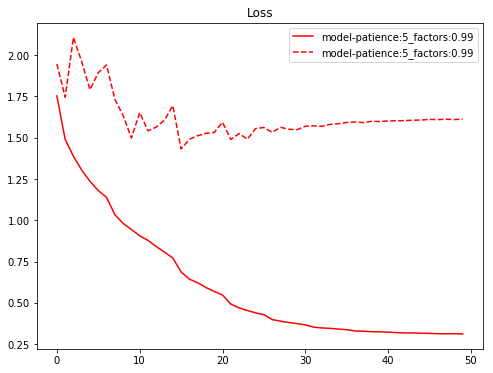

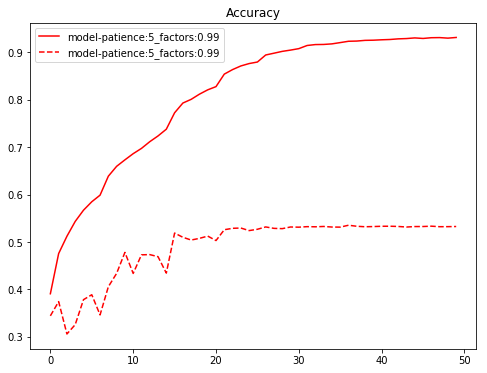

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k", "gray","c","purple"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 10s 199us/step - loss: 0.4506 - acc: 0.8708 - val_loss: 1.5287 - val_acc: 0.5381
Epoch 46/50
50000/50000 [==============================] - 10s 206us/step - loss: 0.4497 - acc: 0.8715 - val_loss: 1.5290 - val_acc: 0.5377
Epoch 47/50
50000/50000 [==============================] - 10s 199us/step - loss: 0.4492 - acc: 0.8711 - val_loss: 1.5338 - val_acc: 0.5371
Epoch 48/50
50000/50000 [==============================] - 11s 213us/step - loss: 0.4480 - acc: 0.8729 - val_loss: 1.5318 - val_acc: 0.5370

Epoch 00048: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 49/50
50000/50000 [==============================] - 11s 221us/step - loss: 0.4464 - acc: 0.8740 - val_loss: 1.5332 - val_acc: 0.5369
Epoch 50/50
50000/50000 [==============================] - 10s 205us/step - loss: 0.4466 - acc: 0.8733 - val_loss: 1.5331 - val_acc: 0.5369


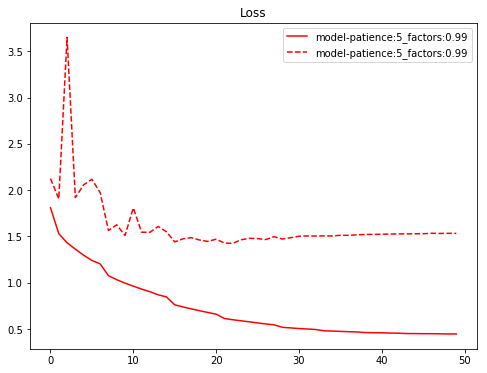

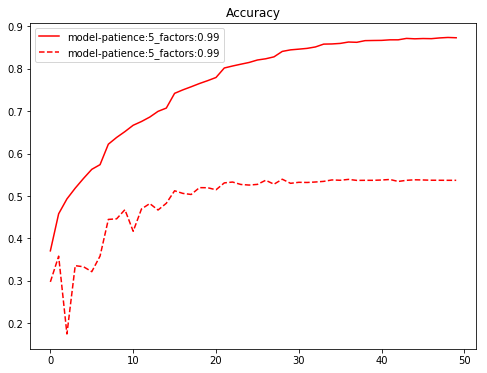

In [21]:
results = {}

keras.backend.clear_session()

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.RMSprop(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], 
              optimizer=optimizer)



model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[reduce_lr]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]
name_tag = f"model-patience:{str(pat)}_factors:{fac}"
results[name_tag] = {'train-loss': train_loss,
             'valid-loss': valid_loss,
             'train-acc': train_acc,
             'valid-acc': valid_acc}


import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k", "gray","c","purple"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()